# DSCI-235-Project

Baseball is known for its plethora of data to be analyzed within the game. At the center of that is Statcast. A tracking system that collects data on several data points during a Major League Baseball game. The data set I chose for this project is a publically accessable Statcast data set from every pitch during the 2021 MLB season. The data include over 700,000 rows with over 35 variables describing the data. These variabes range from how fast each pitch was thrown to how fast the ball was hit off the bat, if it was hit on that pitch.  A description of all variables I will use can be found at: https://baseballsavant.mlb.com/csv-docs

------
Questions I intend to answer with this data set.
1. Which team has the highest/lowest average fastball pitch speed from their pitchers?
2. Which team has the highest/lowest average hit speed from their hitters?
3. Which team has "unluckiest" teams? 
4. Do right handed or left handed batters get shifted upon more often? 
5. Do teams tend to score more runs while playing at home or away?




In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%autosave 60

Autosaving every 60 seconds


In [4]:
df = pd.read_csv('/content/baseball.csv')
df.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_y,release_pos_z,events,description,stand,p_throws,...,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,babip_value,post_away_score,post_home_score,if_fielding_alignment,of_fielding_alignment,delta_home_win_exp,delta_run_exp
0,FF,4/5/2021,93.2,0.84,0.84,5.74,strikeout,swinging_strike,L,L,...,NaN,NaN,0.0,0.0,2,0,Infield shift,Standard,-0.014,-0.134
1,SL,4/5/2021,82.9,1.03,1.03,5.69,NaN,foul,L,L,...,NaN,NaN,NaN,NaN,2,0,Infield shift,Standard,0.000,0.000
2,FF,4/5/2021,94.6,-1.85,-1.85,5.77,caught_stealing_3b,ball,R,R,...,NaN,NaN,0.0,0.0,4,0,Standard,Standard,0.014,-0.261
3,FF,4/5/2021,93.6,0.60,0.60,5.85,NaN,ball,L,L,...,NaN,NaN,NaN,NaN,2,0,Infield shift,Standard,0.000,0.043
4,FF,4/5/2021,97.1,1.86,1.86,6.57,field_out,hit_into_play,R,L,...,0.277,0.261,0.0,0.0,6,0,Standard,Standard,-0.007,-0.264


## Question 1: Which team has the highest/lowest average fastball pitch speed from their pitchers?

In the dataset, we have home and away team and what inning the pitch is thrown in. We can determine the team the pitcher is on from these variables. If the pitch is thrown in the top of the inning, the home teams pitcher is throwing the ball. If the ball is thrown in the bottom of an inning, the away team pitcher is throwing. To find the average fastball, we need to use the pitch type  column. However, there are different kinds of fastballs labeled 'FF', 'SI', and 'FA'. I will relabel all pitches to be easier to understand.

   pitch_type1 pitcher_team  release_speed
0     Fastball          NYY      94.689674
1     Fastball          CWS      94.620833
2     Fastball          LAD      94.423728
3     Fastball          BOS      94.412111
4     Fastball          COL      94.256357
5     Fastball          PHI      94.218120
6     Fastball          CIN      94.190790
7     Fastball          ATL      94.170522
8     Fastball          DET      94.134083
9     Fastball          NYM      94.083660
10    Fastball          MIA      93.982807
11    Fastball           SD      93.896752
12    Fastball           KC      93.894307
13    Fastball           TB      93.804768
14    Fastball          TOR      93.722672
15    Fastball          MIL      93.350233
16    Fastball          CLE      93.197149
17    Fastball          PIT      93.161605
18    Fastball          WSH      93.124741
19    Fastball          SEA      93.013104
20    Fastball          TEX      93.004214
21    Fastball          BAL      92.976848
22    Fastb

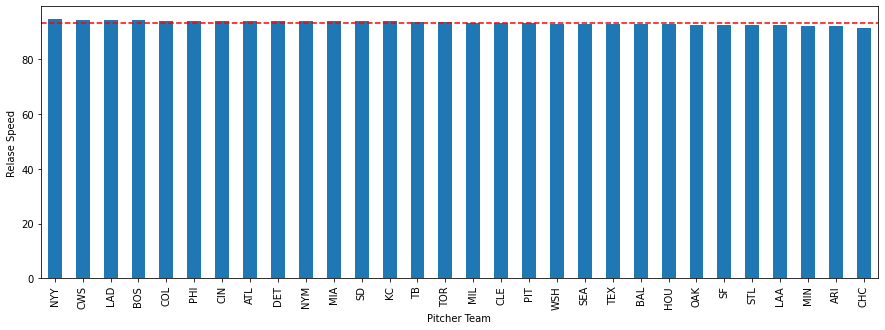

In [5]:
# Create new column for pitcher team
df['pitcher_team'] = np.where(df['inning_topbot'] == 'Top', df['home_team'], df['away_team'])

df['pitch_type1'] = np.where((df['pitch_type'] == 'FF') | (df['pitch_type'] == 'SI') | (df['pitch_type'] == 'FA'), 'Fastball',
                            np.where((df['pitch_type'] == 'CH'), 'Changeup',
                                     np.where((df['pitch_type'] == 'CS') | (df['pitch_type'] == 'CU') | (df['pitch_type'] == 'SC') | 
                                              (df['pitch_type'] == 'KC'), 'Curveball',
                                              np.where((df['pitch_type'] == 'EP'), 'Eephus',
                                                       np.where((df['pitch_type'] == 'KN'), 'Knuckleball',
                                                                np.where((df['pitch_type'] == 'SL'), 'Slider', 
                                                                         np.where((df['pitch_type'] == 'FS'), 'Splitter',"Unidentified")))))))
# Group by each team
pitchers_team = df[df['pitch_type1'] == "Fastball"].groupby(['pitch_type1','pitcher_team'])['release_speed'].mean().sort_values(ascending = False)


pitchers_team = pitchers_team.reset_index()
print(pitchers_team)



pitchers_team.plot(x = 'pitcher_team', y = 'release_speed', kind = 'bar', figsize = (15, 5), legend = False, 
                  ylabel = "Relase Speed", xlabel = "Pitcher Team")
plt.axhline(y=np.mean(pitchers_team['release_speed']), color = "red", linestyle = "dashed")

Looking at the bar plot of how fast on average each team throws a fastball, the results are very similar throughout. The New York Yankees lead the way with an average fastball speed of 94.68 MPH while the Chicago Cubs are at the bottom with an average fastball speed of 91.63 MPH. This is a difference of about 3 MPH. That seems small in the bar graph but is a big gap over the course of a season. The dashed red line represents league average.

## Question 2: Which team has the highest/lowest average hit speed from their hitters?

To separate each hitter into their own team, I need to create a new column for each hitter. If a hitter is hitting in the top of an inning, they are the away team. If they are hitting in the bottom of an inning, they are on the home team.

   hitter_team  launch_speed
0          MIN     83.599503
1          NYY     83.539677
2          TOR     83.504869
3          BOS     83.070012
4          LAD     82.961292
5          ATL     82.832439
6          HOU     82.828948
7          OAK     82.678779
8           SD     82.662562
9           KC     82.606858
10         CLE     82.482154
11         STL     82.337435
12          TB     82.336775
13         CWS     82.228539
14         CHC     82.145447
15          SF     82.135727
16         WSH     82.040283
17         BAL     81.934560
18         MIL     81.840000
19         LAA     81.752916
20         DET     81.742730
21         NYM     81.703482
22         TEX     81.636779
23         PHI     81.612684
24         CIN     81.602533
25         ARI     81.527910
26         MIA     81.504059
27         SEA     81.411869
28         PIT     81.305403
29         COL     81.242808


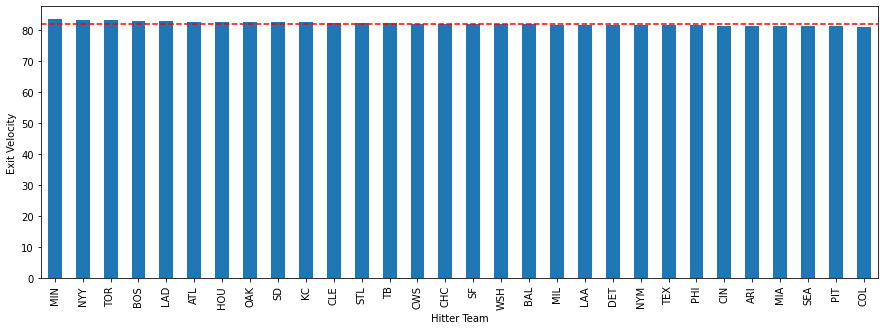

In [6]:
# Create new column for hitter team
df['hitter_team'] = np.where(df['inning_topbot'] == 'Top', df['away_team'], df['home_team'])

# Group by each team
hitters_team = df.groupby('hitter_team')['launch_speed'].mean().sort_values(ascending = False)

hitters_team = hitters_team.reset_index()
print(hitters_team)



hitters_team.plot(x = 'hitter_team', y = 'launch_speed', kind = 'bar', figsize = (15, 5), legend = False, 
                  ylabel = "Exit Velocity", xlabel = "Hitter Team")
plt.axhline(y=np.mean(hitters_team['launch_speed']), color = "red", linestyle = "dashed")

Looking at the bar plot of how fast on average each team hits the ball, the results are very similar throughout, just like with pitcher fastball speed. The Minnesota Twins lead the way with an average hit speed speed of 83.59 MPH while the Colorado Rockies are at the bottom with an average hit speed of 81.24 MPH. This is an even smaller difference than that of the top and bottom of pitcher fastball speed.

## Question 3: Which team has "unluckiest" hitters?

The key to winning baseball games is to get more runs than the other team. Runs come in a wide variety of ways but they start with getting runners on base and then hitting them in to score. How runners get on base is through a variety of ways, some more important than others. A baseball statistic that is used to measure a hitters skill is weighted on base average (wOBA). wOBA is a statistic that weights each event in a baseball game that will explain how runs are scored. A hit like a triple and home run will lead to more runs (and wins) than a single. Major League Baseball has a model already created using how hard the ball was hit and the vertical angle to estimate the wOBA value for a batted ball. The obseerved wOBA value is also supplied. Sometimes a hitter will hit the ball really hard but right at a fielder. This will lead to an out but since the ball was hit hard, the model will estimate a higher value than 0. This can lead to some 'unlucky' teams. Using this model of the expected wOBA and the observed wOBA, I will compare which teams were most 'unlucky' where their expected results were higher than there actual results. Over the long run, the expected reuslts should equal the actual results.

In the data set, the estimated wOBA is the column 'estimated_woba_using_speedangle' while the column of the actual result is called 'woba_value'. I will find the difference in these two values on average per team and find the 'unluckiest' team.

Text(0, 0.5, 'Launch Angle (Degrees)')

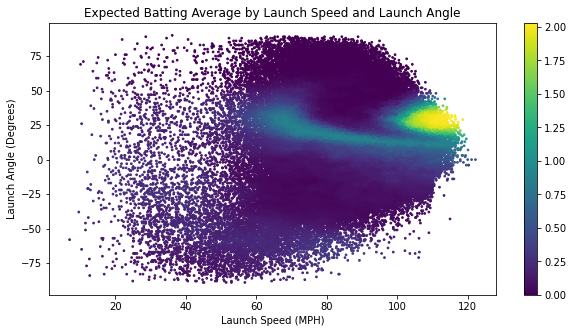

In [9]:
plt.figure(figsize=(10,5))
plt.scatter(df['launch_speed'], df['launch_angle'], c=df['estimated_woba_using_speedangle'], s = 3)
plt.colorbar()
plt.title("Expected wOBA by Launch Speed and Launch Angle")
plt.xlabel("Launch Speed (MPH)")
plt.ylabel("Launch Angle (Degrees)")

This plot represents how fast the ball is hit on the x-axis and the vertical angle the ball was hit on the y-axis. Together these variables form a relationship with the estimated wOBA. The color in this plot represents just that. There seeems to be a clean non-linear relationship.

Text(0, 0.5, 'Launch Angle (Degrees)')

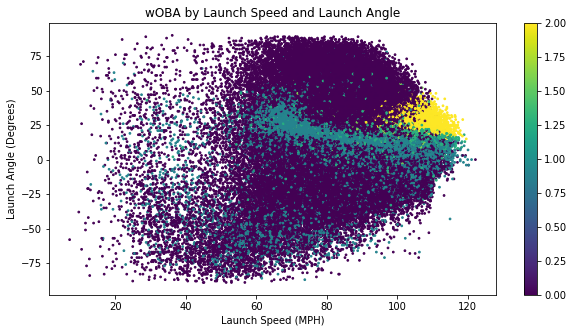

In [10]:
plt.figure(figsize=(10,5))
plt.scatter(df['launch_speed'], df['launch_angle'], c=df['woba_value'], s = 3)
plt.colorbar()
plt.title("wOBA by Launch Speed and Launch Angle")
plt.xlabel("Launch Speed (MPH)")
plt.ylabel("Launch Angle (Degrees)")

In [19]:
clean = df.dropna(subset = ['estimated_woba_using_speedangle'])
len(clean)

121316

Here is the same graph with the observed results of the observed wOBA based on its metrics. This graph shows a similar result to the expected results in the graph above. 

My next step is to take the average wOBA and comparing that to estimated wOBA to see which team has the largest difference.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


hitter_team
MIN    0.009182
NYY    0.004671
OAK    0.001572
SEA   -0.001527
ATL   -0.004577
STL   -0.007710
KC    -0.007833
SD    -0.008385
PIT   -0.008715
TEX   -0.010358
NYM   -0.011787
LAA   -0.013784
LAD   -0.015175
CLE   -0.015295
DET   -0.015363
BOS   -0.015523
BAL   -0.015794
MIL   -0.017321
WSH   -0.017715
CIN   -0.018320
HOU   -0.018742
PHI   -0.020763
MIA   -0.020764
TOR   -0.021317
SF    -0.023741
ARI   -0.025818
CWS   -0.026432
CHC   -0.030309
COL   -0.031335
TB    -0.039003
Name: woba_expected, dtype: float64


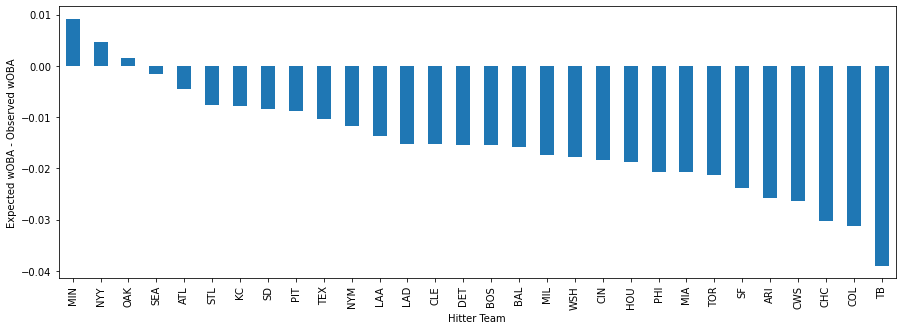

In [20]:
clean = df.dropna(subset = ['estimated_woba_using_speedangle'])
clean['woba_expected'] = clean['estimated_woba_using_speedangle'] - clean['woba_value'] 

# Group by each team
grouped = clean.groupby('hitter_team')['woba_expected'].mean().sort_values(ascending = False)
print(grouped)

grouped.plot(kind = 'bar', figsize = (15, 5), legend = False, 
                  ylabel = "Expected wOBA - Observed wOBA", xlabel = "Hitter Team")

This bar graph shows the expected wOBA minus the observed wOBA. The higher the value, the more the team was 'unlucky', meaning they were expected to perform better than they actually did. One thing to point out is that over the long run, these two values should have a difference of 0 but only three teams had a difference in these two statistics above 0. That means there could possibly be a flaw in the model that is predicting the probability of a hit that came with the data. According to this graph, the Minnesota Twins were the 'unluckiest' team with a difference in expected wOBA and observed wOBA of 0.0091. The 'luckiest' team was the Tampa Bay Rays with a difference of -0.039. 